In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [2]:
training_epochs = 20
batch_size = 32
learning_rate = 1e-3

In [3]:
filename = 'splitted_dataset.npz'
dataset = np.load(filename)

In [4]:
inputs_train = dataset['inputs_train']
inputs_test  = dataset['inputs_test']
labels_train = dataset['labels_train']
labels_test  = dataset['labels_test']

In [5]:
class Custom_dataset(Dataset):
    
    def __init__(self, inputs, labels):
        self.inputs = torch.from_numpy(inputs).float()
        self.labels = torch.from_numpy(labels).long()
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        inputs = self.inputs[index]
        labels = self.labels[index]
        return inputs, labels

In [6]:
train_set = Custom_dataset(inputs = inputs_train,
                           labels = labels_train)
test_set  = Custom_dataset(inputs = inputs_test,
                           labels = labels_test)

In [7]:
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)
test_loader  = DataLoader(dataset=test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          drop_last=False)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder Layers
        self.Enc1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        
        self.Enc2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
        )
        
        self.Enc3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU()
        )
        
        self.Enc4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU()
        )
        
        self.Pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder Layers
        self.Dec1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU()
        )
        
        self.Dec2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
        )
        
        self.Dec3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        
        self.Dec4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU()
        )
        
        self.UnPool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.Sigmoid = nn.Sigmoid()
        self.ReLU = nn.ReLU()
        
    def forward(self, inputs):
        # Encode
        outputs = self.Enc1(inputs)
        outputs, indices1 = self.Pool(outputs)
        
        outputs = self.Enc2(outputs)
        outputs, indices2 = self.Pool(outputs)
        
        outputs = self.Enc3(outputs)
        outputs, indices3 = self.Pool(outputs)
        
        outputs = self.Enc4(outputs)
        outputs, indices4 = self.Pool(outputs)

        # Decode

        outputs = self.UnPool(outputs, indices4, output_size=torch.Size([1, 8, 32, 47]))
        outputs = self.Dec1(outputs)
        
        outputs = self.UnPool(outputs, indices3, output_size=torch.Size([1, 16, 64, 95]))
        outputs = self.Dec2(outputs)
        
        outputs = self.UnPool(outputs, indices2, output_size=torch.Size([1, 32, 128, 191]))
        outputs = self.Dec3(outputs)
        
        outputs = self.UnPool(outputs, indices1, output_size=torch.Size([1, 64, 257, 382]))
        outputs = self.Dec4(outputs)
        
        outputs = self.ReLU(outputs)
        return outputs
    

In [9]:
GPU_NUM = 6
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Currernt cuda device ', torch.cuda.current_device())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Currernt cuda device  6
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
AE = AutoEncoder().to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

In [12]:
total_batch = len(train_loader)


for epoch in range(training_epochs):
    avg_cost = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)

        optimizer.zero_grad()
        hypothesis = AE(inputs)
        cost = criterion(hypothesis, inputs)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    
    print('[Epoch : {:>4}] '.format(epoch + 1))
    print('cost = {:>.9}'.format(avg_cost))
print('Learning finished')

[Epoch :    1] 
cost = 0.028916683
[Epoch :    2] 
cost = 0.00641117897
[Epoch :    3] 
cost = 0.00597968418
[Epoch :    4] 
cost = 0.00562475761
[Epoch :    5] 
cost = 0.00544062117
[Epoch :    6] 
cost = 0.00504110195
[Epoch :    7] 
cost = 0.00476914784
[Epoch :    8] 
cost = 0.00465579657
[Epoch :    9] 
cost = 0.00433415873
[Epoch :   10] 
cost = 0.0058499421
[Epoch :   11] 
cost = 0.00483074039
[Epoch :   12] 
cost = 0.00423595682
[Epoch :   13] 
cost = 0.0040350738
[Epoch :   14] 
cost = 0.00383389881
[Epoch :   15] 
cost = 0.00381561415
[Epoch :   16] 
cost = 0.00435996568
[Epoch :   17] 
cost = 0.00424144045
[Epoch :   18] 
cost = 0.00365121523
[Epoch :   19] 
cost = 0.00399455009
[Epoch :   20] 
cost = 0.00320357038
Learning finished


In [13]:
ReConst = torch.FloatTensor(1, 2, 257, 382)

In [14]:
with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)
        outputs = AE(images)
        ReConst = torch.cat((ReConst, outputs.to('cpu')), 0)


In [15]:
import matplotlib.pyplot as plt

In [16]:
ReConst = ReConst[1:401]

58


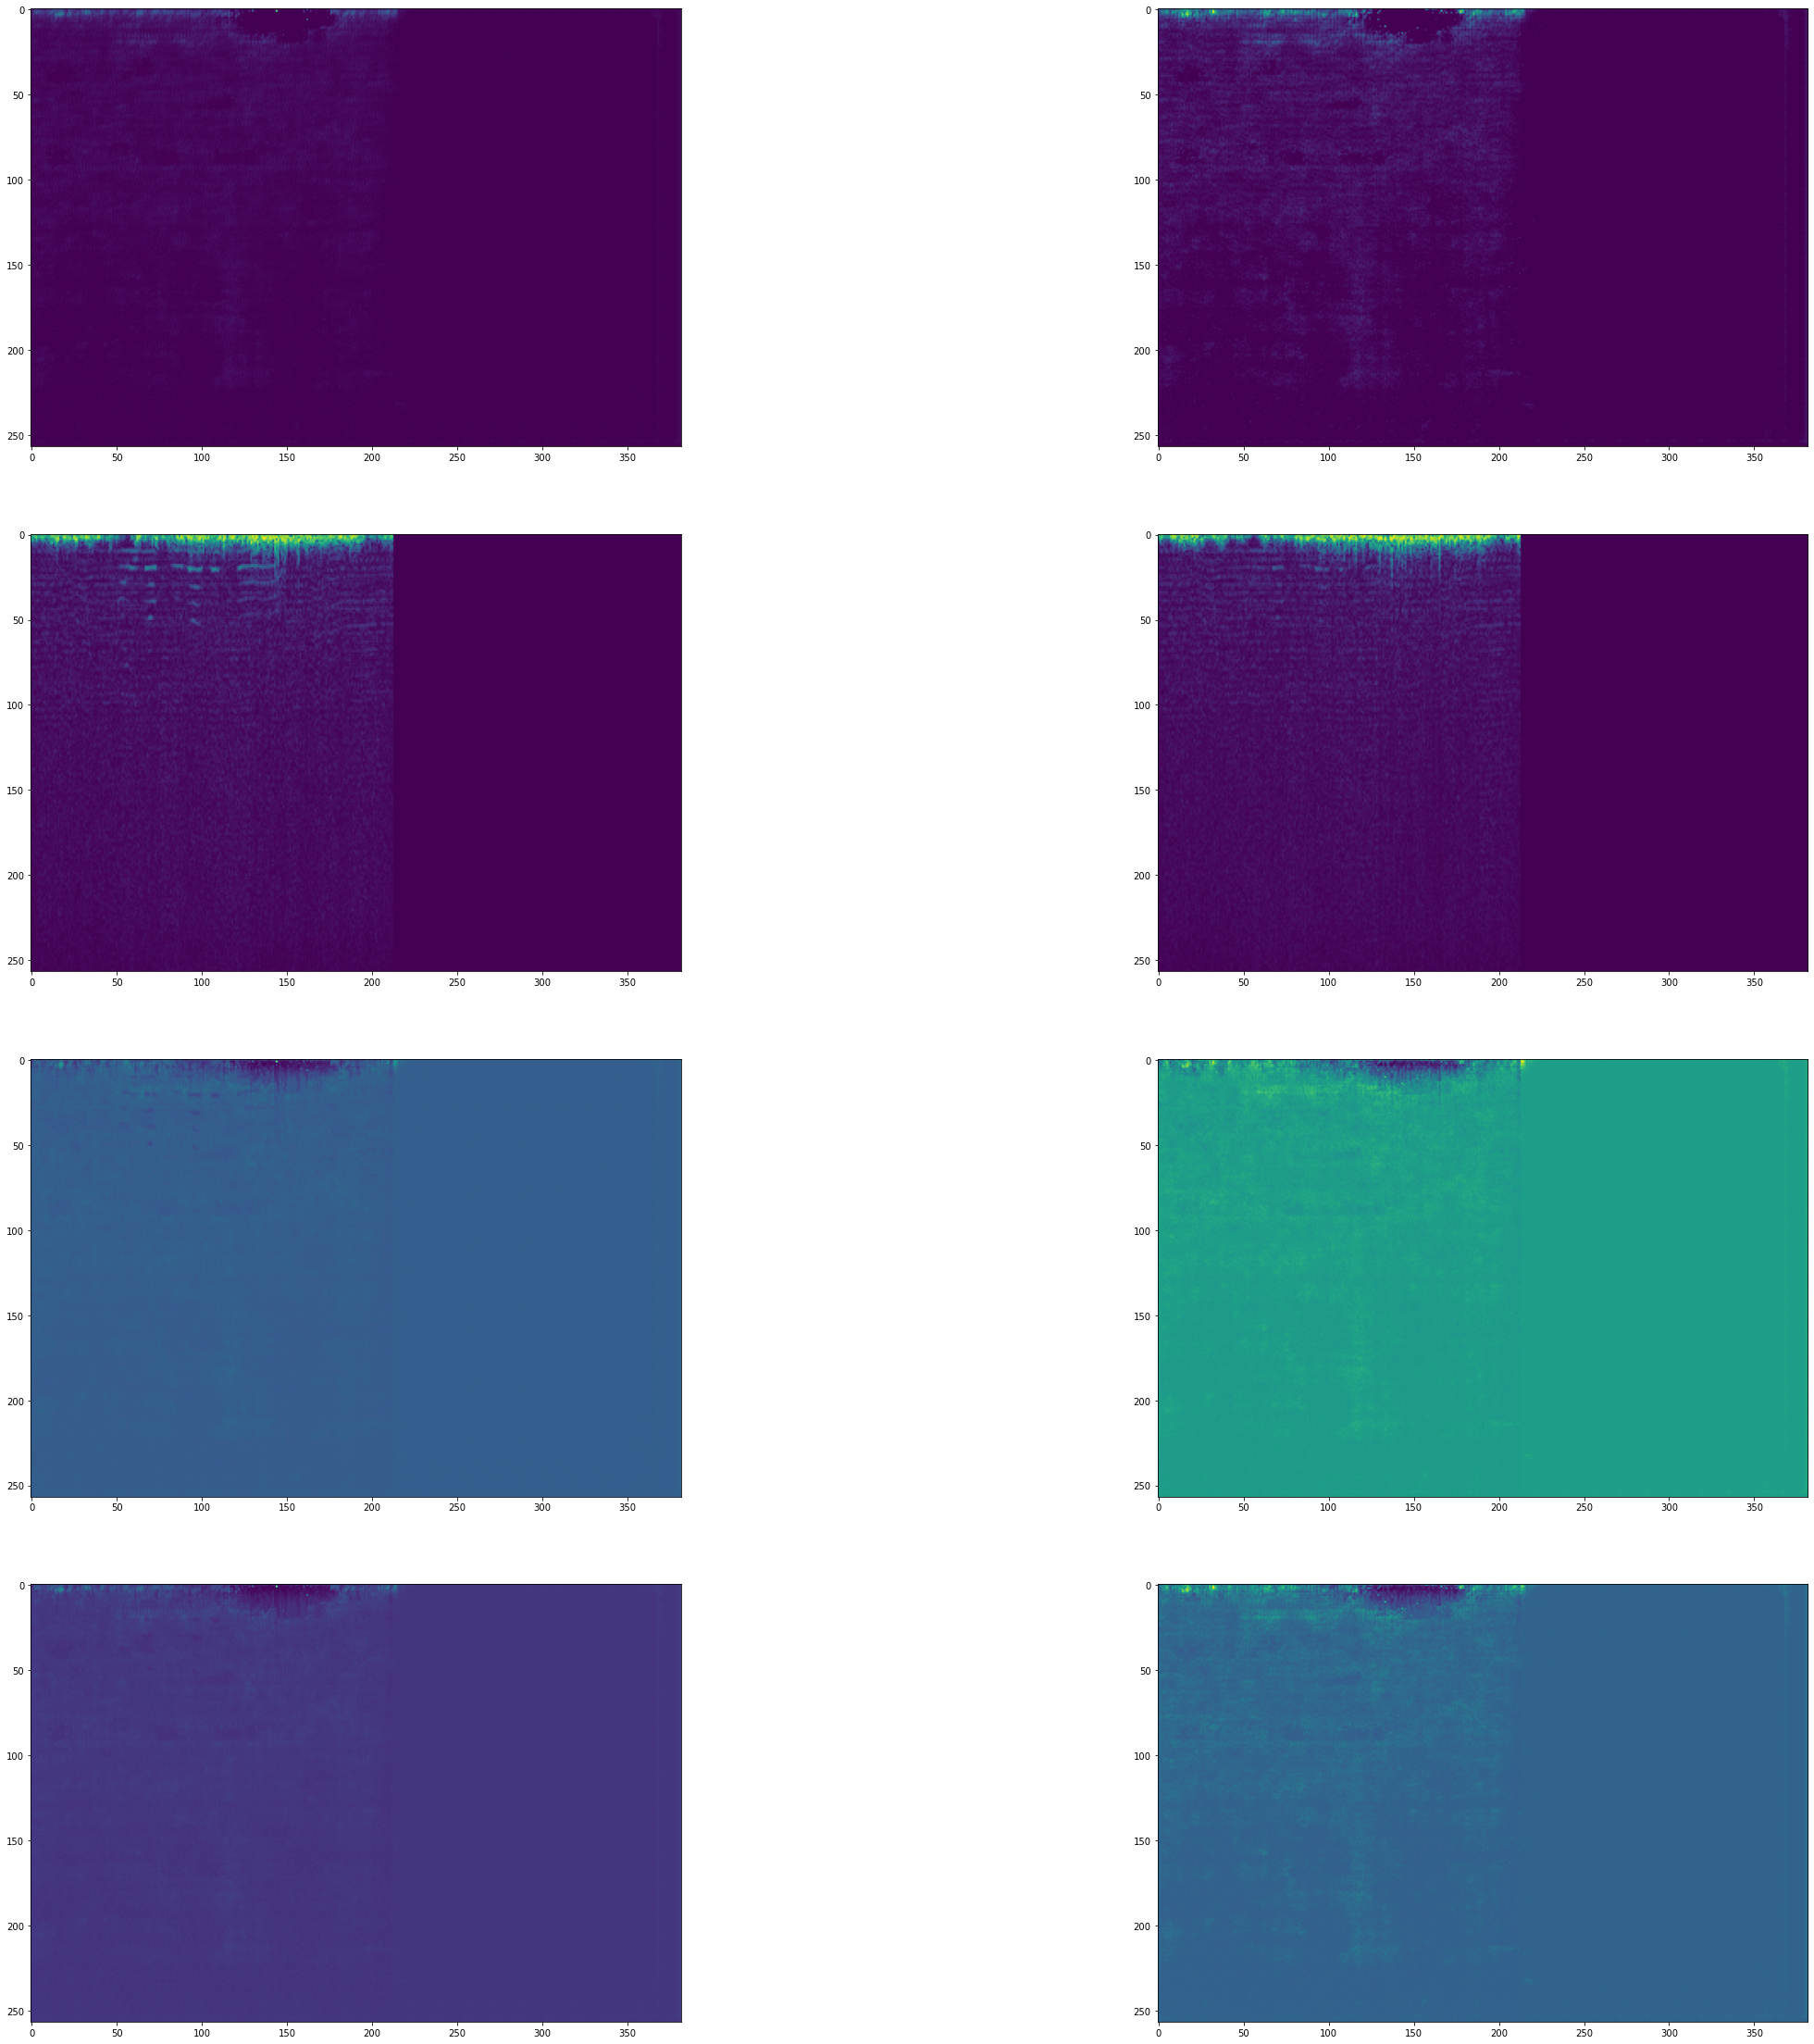

In [45]:
index = np.random.randint(0,400)
print(index)
fig = plt.figure(figsize=(40,40))

fig1 = fig.add_subplot(4, 2, 1)
fig1.imshow(ReConst[index, 1])

fig2 = fig.add_subplot(4, 2, 2)
fig2.imshow(ReConst[index, 0])

fig3 = fig.add_subplot(4, 2, 3)
fig3.imshow(inputs_test[index, 1])

fig4 = fig.add_subplot(4, 2, 4)
fig4.imshow(inputs_test[index, 0])

fig5 = fig.add_subplot(4, 2, 5)
fig5.imshow(ReConst[index, 1].numpy() - inputs_test[index, 1])

fig6 = fig.add_subplot(4, 2, 6)
fig6.imshow(ReConst[index, 0].numpy() - inputs_test[index, 0])

fig7 = fig.add_subplot(4, 2, 7)
fig7.imshow(ReConst_norm[index, 1])

fig8 = fig.add_subplot(4, 2, 8)
fig8.imshow(ReConst_norm[index, 0])

plt.show()

In [40]:
ReConst_norm =  ReConst.numpy()- (inputs_test - ReConst.numpy())

In [41]:
for i in range(len(ReConst_norm)):
    ReConst_norm[i] = np.divide(np.subtract(ReConst_norm[i], ReConst_norm[i].mean()),
                             ReConst_norm[i].std())
    ReConst_norm[i] = np.divide(np.subtract(ReConst_norm[i], ReConst_norm[i].min()),
                             np.subtract(ReConst_norm[i].max(), ReConst_norm[i].min() ))